In [1]:
import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt

# Input space transformation (dimensionality reduction)
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import random_projection
from sklearn import cluster
from sklearn.random_projection import johnson_lindenstrauss_min_dim

import utils
from model import My_VGG as Model

from DCTDimReducer import DCTDimReducer
from ClusteringAdvClassifier import ClusterAdversarialClassifier as Classifier

# Testing Cluster Adversarial Classifier

## Load Data

In [2]:
# MNIST
# X_train, y_train, X_test, y_test = utils.load_mnist(normalize=True)
# dataset = "MNIST"
# channels, size, classes = 1, 28, 10
# dimensions = (size, size)

# Fashion MNIST
# X_train, y_train, X_test, y_test = utils.load_fashion_mnist(normalize=True)
# dataset = "FMNIST"
# channels, size, classes = 1, 28, 10
# dimensions = (size, size)

# CIFAR-10 # grayscale
# X_train, y_train, X_test, y_test = utils.load_cifar10(normalize=True, grayscale=True)
# dataset = "GRAY_CIFAR10"
# channels, size, classes = 1, 32, 10
# dimensions = (size, size, channels)

# CIFAR-10 # grayscale
X_train, y_train, X_test, y_test = utils.load_cifar10(normalize=True)
dataset = "CIFAR10"
channels, size, classes = 3, 32, 10
dimensions = (size, size, channels)

Files already downloaded and verified
Files already downloaded and verified


## Load Baseline (standalone) Model

In [3]:
adversarially_trained = False

if adversarially_trained:
    model_name = 'adv_trained_'+ dataset + '_model'
else:
    model_name = dataset + '_model'

baseline_model = utils.load_VGG('trained_models/' + model_name + '.pt')

## Train Clustering Classifier

### Load Base Neural Network For Clustering Detector/Classifier

In [4]:
model = utils.load_VGG('trained_models/' + model_name + '.pt')
baseline_model.eval()
model.eval()

My_VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d

### Input Space (Dimensionality Reduction) Transforms - optional

In [5]:
# Discrete Cosine Transform
transformer = DCTDimReducer(coef_size_reduction=24)

### Fitting the clustering classifier on clean data

In [6]:
# Best = 100 - better on eps >= 2
classifier = Classifier(model, input_transform=transformer, SVC_C = 100)

classifier.fit(X_train, y_train)

runtime = dict()
runtime['input_cluster_train_time'] = classifier.input_cluster_train_time
runtime['output_cluster_train_time'] = classifier.output_cluster_train_time
runtime['dim_reduction_time'] = transformer.transform_time
print(runtime)

C:\Users\Jason\anaconda3\envs\ml\lib\site-packages\sklearn\svm\_base.py:284: ConvergenceWarning: Solver terminated early (max_iter=100000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


{'input_cluster_train_time': 2573.368428468704, 'output_cluster_train_time': 2.3835020065307617, 'dim_reduction_time': 8.974010705947876}


## Evaluation

### Scoring classifiers on clean data

In [7]:
print("Baseline classifier on clean test data: %.3f%%" % (utils.eval_model(baseline_model, X_test, y_test) * 100))

print("\nCluster Classifier Accuracy on clean test data: %.3f%%" % (classifier.score(X_test, y_test) * 100))
print("Clean data flagged as suspicious by detector: %.3f%%" % (classifier.proportion_flagged * 100))

Baseline classifier on clean test data: 80.670%

Cluster Classifier Accuracy on clean test data: 43.270%
Clean data flagged as suspicious by detector: 56.490%


## Evaluating on adversarial data

Baseline training epsilon: 0.30

Current epsilon: 0.10


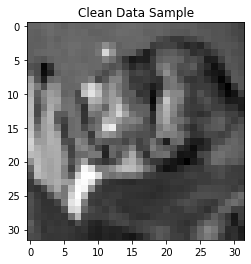

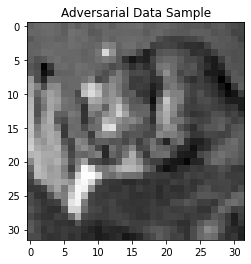

	Adversarial data only:
		Baseline classifier accuracy: 0.219

		Cluster classifier accuracy: 0.431
		Clustering algorithm accuracy: 0.420
		Model accuracy: 0.464
		Input data flagged as suspicious by detector: 0.760


In [8]:
test_eps = [.1]#, .3, .6, 1, 1.5, 2, 3]
print("Baseline training epsilon: %.2f" % (3e-1))

baseline_performance = dict()
clustering_classifier_performance = dict()
cluster_accuracy = dict()
cnn_accuracy = dict()
clustering_detector_performance = dict()

test_dataloader = utils.create_dataloader(X_test, y_test)

baseline_performance['clean'] = utils.eval_model(baseline_model, X_test, y_test)

# Clustering classifier and adversarial detection accuracy
clustering_classifier_performance['clean'] = classifier.score(X_test, y_test)
cluster_accuracy['clean'] = classifier.cluster_accuracy
cnn_accuracy['clean'] = classifier.cnn_accuracy
clustering_detector_performance['clean'] = 1 - classifier.proportion_flagged

for eps in test_eps:
    adv_test_data = utils.add_adversarial_noise(model, test_dataloader, eps=eps)
    
    print("\nCurrent epsilon: %.2f" % (eps))
    
    plt.imshow(X_test[0].reshape(dimensions), cmap='gray')
    plt.title("Clean Data Sample")
    plt.show()

    plt.imshow(adv_test_data[0].reshape(dimensions), cmap='gray')
    plt.title("Adversarial Data Sample")
    plt.show()
    
    # Testing both classifiers on adversarial data only
    # Baseline accuracy
    baseline_performance[str(eps)] = utils.eval_model(baseline_model, adv_test_data, y_test)
    
    print("\tAdversarial data only:")
    print("\t\tBaseline classifier accuracy: %.3f" % (baseline_performance[str(eps)]))

    # Clustering classifier and adversarial detection accuracy
    clustering_classifier_performance[str(eps)] = classifier.score(adv_test_data, y_test)
    cluster_accuracy[str(eps)] = classifier.cluster_accuracy
    cnn_accuracy[str(eps)] = classifier.cnn_accuracy
    clustering_detector_performance[str(eps)] = classifier.proportion_flagged
    
    print("\n\t\tCluster classifier accuracy: %.3f" % (clustering_classifier_performance[str(eps)]))
    print("\t\tClustering algorithm accuracy: %.3f" % (cluster_accuracy[str(eps)]))
    print("\t\tModel accuracy: %.3f" % (cnn_accuracy[str(eps)]))
    print("\t\tInput data flagged as suspicious by detector: %.3f" % (clustering_detector_performance[str(eps)]))

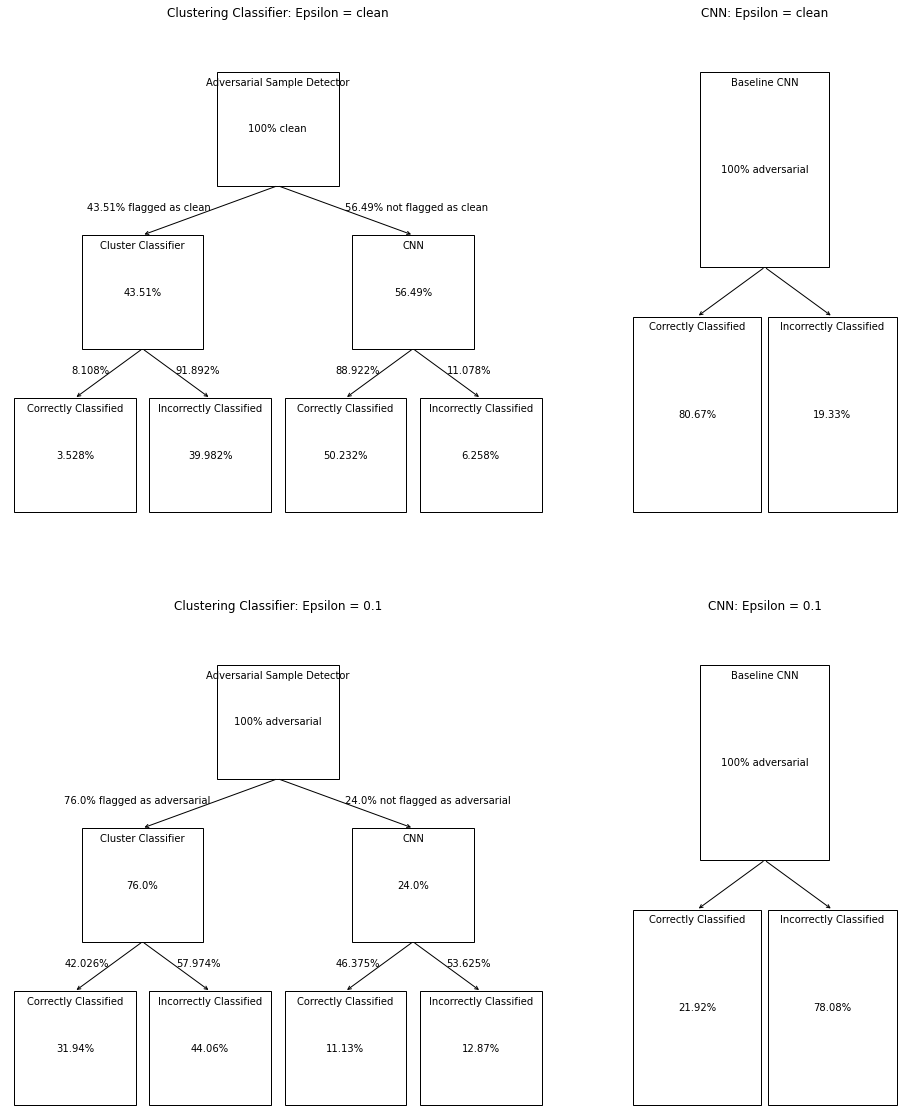

In [9]:
# Clustering classifier results:

# Structure of output:
# Root node: All samples, adversarial sample detector
#     Left child: Percentage of flagged adversarial samples, sent to cluster classifier
#         Left child: percentage of samples correctly classified by cluster classifier
#         Right child: percentage of samples incorrectly classified by cluster classifier
#     Right child: Percentage of non-flagged, "clean" samples, sent to cnn
#         Left child: percentage of samples correctly classified by cnn
#         Right child: percentage of samples incorrectly classified by cnn
node_labels=["Adversarial Sample Detector", "Cluster Classifier", "CNN", "Correctly Classified", 
              "Incorrectly Classified", "Correctly Classified", "Incorrectly Classified"]
absolute_percentages=dict()
relative_percentages=dict()

percentage = lambda x : str(round((x * 100), 3)) + "%"

test_eps.insert(0, 'clean')

for eps in test_eps:
    isAdversarial = 'clean' if eps == 'clean' else 'adversarial'
    
    eps = str(eps)
    eps_absolute_percentages=list()
    eps_relative_percentages=list()

    # Relative percentages
    detected_adversarial = clustering_detector_performance[eps]
    not_detected_adversarial = 1 - clustering_detector_performance[eps]

    cluster_classified_correctly = cluster_accuracy[eps]
    cluster_classified_incorrectly = 1 - cluster_accuracy[eps]

    cnn_classified_correctly = cnn_accuracy[eps]
    cnn_classified_incorrectly = 1 - cnn_accuracy[eps]

    # Absolute percentages
    detector_received = 1

    cluster_received = detected_adversarial
    cnn_received = not_detected_adversarial

    cluster_received_correctly_classified = detected_adversarial * cluster_classified_correctly
    cluster_received_incorrectly_classified = detected_adversarial * cluster_classified_incorrectly

    cnn_received_correctly_classified = not_detected_adversarial * cnn_classified_correctly
    cnn_received_incorrectly_classified = not_detected_adversarial * cnn_classified_incorrectly


    # Percentage of samples sent to cluster classifier (correctly classified as adversarial)
    eps_relative_percentages.append(percentage(detected_adversarial) + " flagged as " + isAdversarial)
    # Percentage of samples sent to cnn (incorrectly classified as clean)
    eps_relative_percentages.append(percentage(not_detected_adversarial) + " not flagged as " + isAdversarial)

    # Percentage of samples received by clustering classifier that were correctly classified
    eps_relative_percentages.append(percentage(cluster_classified_correctly))    
    # Percentage of samples received by clustering classifier incorrectly classified
    eps_relative_percentages.append(percentage(cluster_classified_incorrectly))

    # Percentage of samples received by cnn that were correctly classified
    eps_relative_percentages.append(percentage(cnn_classified_correctly))    
    # Percentage of samples received by cnn that were incorrectly classified
    eps_relative_percentages.append(percentage(cnn_classified_incorrectly))
    
    relative_percentages[eps] = eps_relative_percentages

    eps_absolute_percentages.append(percentage(detector_received) + " " + isAdversarial) # 100% of samples are viewed by the root node (detector)

    # Percentage of samples sent to cluster classifier (correctly classified as adversarial)
    eps_absolute_percentages.append(percentage(cluster_received))
    # Percentage of samples sent to cnn (incorrectly classified as clean)
    eps_absolute_percentages.append(percentage(cnn_received))

    # Percentage of all samples correctly classified by clustering classifier
    eps_absolute_percentages.append(percentage(cluster_received_correctly_classified))    
    # Percentage of all samples incorrectly classified by clustering classifier
    eps_absolute_percentages.append(percentage(cluster_received_incorrectly_classified))

    # Percentage of all samples correctly classified by cnn
    eps_absolute_percentages.append(percentage(cnn_received_correctly_classified))    
    # Percentage of all samples incorrectly classified by cnn
    eps_absolute_percentages.append(percentage(cnn_received_incorrectly_classified))
    
    absolute_percentages[eps] = eps_absolute_percentages
    
# Baseline model results:

# Structure of output:
# Root node: All samples, CNN
#     Left child: percentage of samples correctly classified by cnn
#     Right child: percentage of samples incorrectly classified by cnn
bl_node_labels=["Baseline CNN", "Correctly Classified", "Incorrectly Classified"]
bl_percentages=dict()

for eps in test_eps:
    eps = str(eps)
    eps_bl_percentages=["100% adversarial", percentage(baseline_performance[eps]), percentage(1 - baseline_performance[eps])]
    bl_percentages[eps] = eps_bl_percentages

_, axes = plt.subplots(nrows=len(test_eps), ncols=2, figsize=(16,10 * len(test_eps)), gridspec_kw=dict(width_ratios=[2,1]))
for i, eps in enumerate(test_eps):
    eps = str(eps)
    axes[i, 0].set_axis_off()
    axes[i, 0].set_title("Clustering Classifier: Epsilon = " + eps)

    utils.visualize_full_binary_tree(3, node_labels, absolute_percentages[eps], relative_percentages[eps], 
                                     ax=axes[i, 0], text_size='medium')
    
    axes[i, 1].set_axis_off()
    axes[i, 1].set_title("CNN: Epsilon = " + eps)

    utils.visualize_full_binary_tree(2, bl_node_labels, bl_percentages[eps], ax=axes[i, 1], text_size='medium')

plt.savefig('Images/' + model_name + '_results.png')
plt.show()